In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Question 2. Matrix Factorization with Regularization (33 points)

There is a user-item matrix, M available where nonzero elements of the matrix are ratings that a user has
for an item. The objective of matrix factorization is to learn a low-rank factorization of M. It decomposes
a large matrix into products of matrices, namely, M = U × V


## 1.)
In order to learn matrix U and V, we will minimize following loss function L. In order to overcome
the problem of overfitting, we are going to use matrix factorization with regularization for this
problem. We define the loss function L as follows:

\begin{equation}
L = \sum_{i,j} (M_{i,j} - U_iV_j^T)^2 + \lambda (\sum_i ||U_i||^2 + \sum_j ||V_j||^2)\ \ \ \ \ \text{(1)}
\end{equation}


Use the Alternating Least Squares method to minimize the loss function to learn matrix U and V
(Hint: fix U or V one at a time, derive a closed form solution for the other). Write out pseudocode
for implementing the algorithm. You should clearly show the closed form solution in the updating
step of your pseudocode. 

#### **<u>ANSWER</u>**
Noting from (1) above that $M_{i,j} , U_i, V_j$ are indicative of the $i^{th} and j^{th}$ elements of matrices M,U,V we can rewrite (1) in a vectorized format so as to remove the need for a **for** loop

\begin{equation}
L = (M - UV^T)^2 + \lambda (||U||^2 + ||V||^2)\ \ \ \ \ \text{(2)}
\end{equation}

Where $U = ℝ^{rank\ x\ i}$ and $V = ℝ^{rank\ x\ j}$ and i,j are reflective of $M_{i,j}$ 

Since L is a function of U and V, this objective is non-convex. Note however, that if we fix the set of Variables V and treat them as constants, then the objective is a convex function of U and vice versa

Holding V constant and taking the deriviative of (2) with respect to U yields:

\begin{equation}
\frac{\partial}{\partial U} L \\ 
= 2(M - UV^T)V + 2 \lambda U \\
= 2VM^T - 2UVV^T + 2 \lambda U\ \ \ \ \ \text{(3)}
\end{equation}

Dividing (3) by 2, setting it equal to 0 and solving for U yields:

\begin{equation}
VM^T - UVV^T + \lambda U = 0\\
UVV^T + \lambda U = VM^T \\
U (VV^T + \lambda I) = VM^T \\ 
U = (VV^T + \lambda I)^{-1}VM^T\ \ \ \ \text{(4)}
\end{equation}

Since the derivation is exactly the same when holding U constant and solving for V, we arrive at 

\begin{equation}
V = (UU^T + \lambda I)^{-1}UM\ \ \ \ \ \text{(5)}
\end{equation}

Notice (4) ends with $VM^T$ and (5) ends with $UM$. This is because M is an (i x j) matrix, U is a (rank x i) matrix, and V is a (rank x j) matrix. Therefor M must be transposed when dotted with V to line up dimensions.


#### <u>Algorithm <u>

**inputs**: M, rank, lambda, iterations <br>
**outpus**: U, V <br><br>
i,j = shape(M) <br>
Initialize U $\in random(ℝ^{rank\ x\ i})$<br>
for iter = 1, 2, ... iterations: **do**<br>
$\ \ \ \ \ V := (UU^T + \lambda I)^{-1}UM$ <br>
$\ \ \ \ \ U := (VV^T + \lambda I)^{-1}VM^T$ <br>
**end**
    
return U,V

In [2]:
train = pd.read_csv('Q2_train.csv', header=None)
test = pd.read_csv('Q2_test.csv', header=None)

In [3]:
#dimensions = users x ratings
print('{} users ; {} ratings'.format(*train.shape))
train.head()


943 users ; 1682 ratings


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,4.0,3.0,3.0,5.0,0.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def als(M, d, lam, iters):
    #intialize U
    #shape should be rank x M[rows]
    U = np.random.rand(d, M.shape[0])
    
    errors = []
    
    mask = ~(M == 0)
    
    #first iteration will initialize V
    for _ in range(iters):
        
        V = np.linalg.pinv(U.dot(U.T) + lam * np.eye(d)).dot(U.dot(M))
 
        
        U = np.linalg.pinv(V.dot(V.T) + lam * np.eye(d)).dot(V.dot(M.T))
    
        
        reconstructed = U.T.dot(V)
        
        error = mean_squared_error(M[mask], reconstructed[mask])
        
        errors.append(error)
    return errors

In [38]:
def plotit(train, test):
    plt.figure(figsize=(20,8))
    plt.plot(range(len(train)), train, color='yellow', lw=3,label='Train MSE', path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
    plt.plot(range(len(test)), test, color='green', lw=3, label='Test MSE', path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()])
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.title('ALS Error per Iterations')
    plt.legend()
    plt.show()

In [43]:
train_errors = als(M=train.values, d=20, lam=0.01, iters=100)

In [44]:
test_errors = als(M=test.values, d=20, lam=0.01, iters=100)

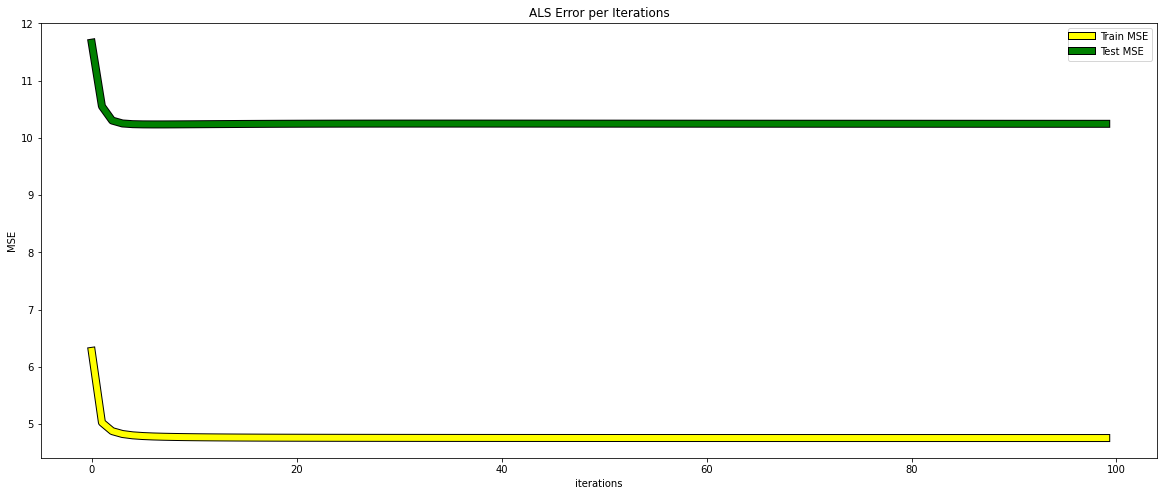

In [45]:
plotit(train_errors, test_errors)

In [159]:
def als2(M, d, lam, iters):
    #intialize U
    #shape should be rank x M[rows]
    U = np.random.rand(d, M.shape[0])
    V = np.random.rand(d, M.shape[1])
    
    u_start = U[:,3].copy()
    errors = []
    
    mask = ~(M == 0)
    rows, cols = np.where(~(M == 0))
    nonzeros = list(zip(rows,cols))
    
    #first iteration will initialize V
    for i in range(iters):
    
        for row, col in nonzeros:
            
            u = U[:,row].reshape(-1,1)
            I = lam * np.eye(d)
            m = M[row,col].reshape(-1,1)

            V[:, col] = np.squeeze(np.linalg.pinv(u.dot(u.T) + I).dot(u.dot(m)))
       
        
        for row, col in nonzeros:
            
            v = V[:,col].reshape(-1,1)
            I = lam * np.eye(d)
            m = M[row,col].reshape(-1,1)
            
            U[:, row] = np.squeeze(np.linalg.pinv(v.dot(v.T) + I).dot(v.dot(m)))
            
    
        if i % 10 == 0: print(i)
        reconstructed = U.T.dot(V)
        
        error = mean_squared_error(M[mask], reconstructed[mask])

        errors.append(error)
    return errors

In [162]:
errs = als2(train.values, 20, 0.01, 100)

KeyboardInterrupt: 

In [ ]:
terrs = als2(test.values, 20, 0.01, 100)

In [ ]:
plotit(errs, terrs)

In [85]:
M = train.values.copy()
U = np.random.rand(20, M.shape[0])
V = np.random.rand(20, M.shape[1])

In [94]:
v[:, 1] = np.ones(20)

In [98]:
v[:, 2].dot(v[:,2].T)

5.902406770039417

In [100]:
v[:,2].dot(v[:,2].T)

5.902406770039417

In [102]:
v[:,2].T.shape

(20,)

In [103]:
v[:,2].shape

(20,)

In [107]:
u = v[:,2].reshape(-1,1)

In [112]:
u.dot(u.T).shape

(20, 20)